Emilio Carrasco Moreno

emilioemail@gmail.com

+34 654642257

-----------------


# Punto 1 y 2

Comentado en PDF

# Punto 2 y 4

Importamos las librerías que vamos a utilizar

In [1]:
from datetime import datetime

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec

import pandas as pd

import seaborn as sns
import  shutil, os

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input



Cargamos el dataset un pandas dataframe y ya escalamos todas las imágenes a un tamaño determinado

In [2]:
img_folder = 'imgs'
label_folder = 'label'

def image_df(path, image_size=(256,256), extension= '.jpg'):
    """
    Función que vuelva el contenido completo de un directorio con imágenes en un dataset.i
    Información por columnas: 
        path: ruta original del archivo.
        file: nombre del archivo.
        image_original_size: imagen original.
        image: imagen escalada.
        size: tamaño original de la imagen.

    Args:
        path (str): ruta del directorio a volcar
        image_size (tuple, optional): tamaño de imagen normalizada. Defaults to (256,256).

    Returns:
        Pandas dataframe.
    """
    
    file_names = os.listdir(path)
    images = [{ 'path': os.path.abspath(os.path.join(img_folder,f)),
                'file': f, 
                'image_original_size': image.load_img(os.path.join(img_folder,f)),
                'image': image.load_img(os.path.join(img_folder,f), target_size=image_size),
                'size': image.load_img(os.path.join(img_folder,f)).size
                 } for f in file_names if f .endswith(extension)]
    return pd.DataFrame(images)


In [3]:
image_size= (200,200)
df = image_df(os.path.join('.',img_folder), image_size= (200,200))

Efectivcamente las imágenes originales tienen diferentes tamaño

In [4]:
df['size'].sample(7)

1214    (320, 240)
1317    (320, 212)
130     (320, 240)
549     (499, 375)
1556    (320, 229)
1119    (320, 249)
455     (320, 284)
Name: size, dtype: object

Creamos una función para visualizar imágenes aleatorias del dataset

In [5]:
def print_flowers(df, num_examples = 9, col='image', size = (15,10)):
    """
    Función que imprime por consola un número imágenes aleatoriamente escogidas de un Pandas dataframe.

    Args:
        df (Pandas dataframe): Dataframe contenedor de imágenes
        num_examples (int, optional): Número de imágenes a mostrar. Defaults to 9.
        col (str, optional): Nombre de la columna que contiene las imágenes. Defaults to 'image'.
        size (tuple, optional): Tamaño de la figura que contiene las imágenes. Defaults to (15,10).

    Returns: None
    """
    
    try:
        num_imgs_df = df.shape[0]
        num_imgs_show = min(num_examples, num_imgs_df)
        
        print("Número de imágenes: ", num_imgs_df)

        df_examples = df.sample(num_imgs_show)
        gs = gridspec.GridSpec(int(np.ceil(np.sqrt(num_imgs_show))), int(np.ceil(np.sqrt(num_imgs_show))))
        plt.figure(figsize = size)

        for i in range(0, num_imgs_show):
            plt.subplot(gs[i])
            plt.imshow(df_examples.reset_index()[col][i])    
            plt.axis('off')
    except Exception as e:
        print("Ha surgido un problemaal imprimir")
        print(e)


Imprimimos imágenes del dataset

Número de imágenes:  1567


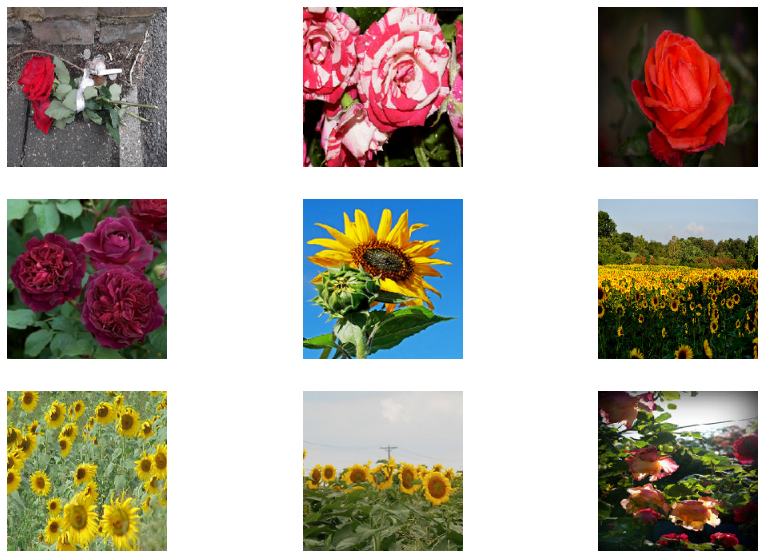

In [6]:
print_flowers(df)

A cada una de estas imágenes le extraemos las features mediante una red preentrenada para imágens. La escogida, por su simplicidad a pesar de haber ganado ImageNet 2012 es la ResNet50. Esta librería preentrenada con imágenes nos permitirá extraer features para nuestro clasificador. Uitlizamos parámetro  de pesos 'imagenet' (pre-entrenamiento con ImageNet) y no incluímos las capas clasificadoras. 

In [7]:
model = ResNet50(weights='imagenet', include_top=False, input_shape= (image_size[0],image_size[1],3))
model.summary()

2021-10-01 15:09:12.035512: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Extraemos todas las feautres de cada imagen

In [8]:
def extract_features(img, model):
    """Función que extrae las features de una imagen.

    Args:
        img (Image): Imagen a extraer futures
        model (Keras engine): Modelo con el que extraer las variables.

    Returns:
        [Numpy array]: Array con todas las features de la imagen.
    """
    x = image.img_to_array(img)
    y = np.expand_dims(x, axis=0)
    z = preprocess_input(y)
    return model.predict(z,  batch_size=32).flatten()


In [9]:
df['features']= df.image.apply(lambda x: extract_features(x,model)) #No he conseguido hacerlo vectorizado con numpy y me he decantado por hacerlo con un apply a sabiendas de lo eficiente que sería en numpy

2021-10-01 15:09:13.106573: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [10]:
print("El vector que obtenemos es de longitud: ", df.loc[0,'features'].shape[0])

El vector que obtenemos es de longitud:  100352


Podemos utilizar “Análisis de Componentes Principales” o PCA para dereeducir el número de variables ya que una imagen existe mucha información redundante.

Lo primero que haremos será calcular la varianza que permanece a pesar de esta reducción.

In [11]:
max_features = 1500 #Ploteamos un máximo de 1500 variables
pca = PCA(n_components = max_features)
pca.fit(df['features'].to_list())
var=np.cumsum(pca.explained_variance_ratio_)

Pediremos mantener cierta varianza para no perder demasiada información en este proceso.

In [12]:
var_min = 0.8
n_features = next(x[0] for x in enumerate(var) if x[1] > var_min)
print('Mantenemos ',n_features,' variables')

Mantenemos  694  variables


Podemos ver como evoluciona la varianza tras el PCA en funcíon del número de variables:

Text(0, 0.5, '% variance')

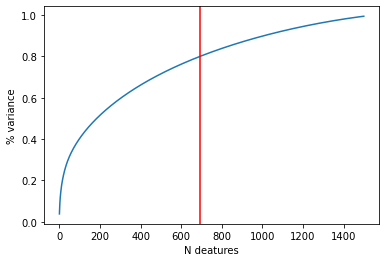

In [13]:
plt.plot(var)
plt.axvline(x=n_features, c='r')

plt.xlabel("N deatures")
plt.ylabel("% variance")

Aplicamos a nuestro array de features el PCA.

In [14]:
pca = PCA(n_components = n_features)
pca.fit(df['features'].to_list())

PCA(n_components=694)

In [15]:

df['features_pca'] = pca.transform(df['features'].tolist()).tolist()

Hemos guardado esta información en una sola columna, desplegamos por comodidad este array a columnas.

Nombramos las columnas:

In [16]:
pca_columns= ["pca_" + str(i+1) for i in range(n_features)]

Desplegamos las variables en las columnas del dataframe:

In [17]:
for i, r in df.iterrows():
    df.loc[i, pca_columns]=r['features_pca'] #seguramente haya un código mucho más eficiente que hacerlo con este for

Y este sería el PD con el que vamos a trabajar:

In [18]:
df.sample(3)

path            file  \
991   /Users/emilio/Trabajo/komorebi/imgs/imagen1219...  imagen1219.jpg   
1129  /Users/emilio/Trabajo/komorebi/imgs/imagen1179...  imagen1179.jpg   
966   /Users/emilio/Trabajo/komorebi/imgs/imagen426.jpg   imagen426.jpg   

                                    image_original_size  \
991   <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1129  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
966   <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                                  image        size  \
991   <PIL.Image.Image image mode=RGB size=200x200 a...  (500, 332)   
1129  <PIL.Image.Image image mode=RGB size=200x200 a...  (500, 334)   
966   <PIL.Image.Image image mode=RGB size=200x200 a...  (240, 159)   

                                               features  \
991   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1129  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
966   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           features_pca      pca_1  \
991   [-64.03464487667163, 177.414677501044, -12.783... -64.034645   
1129  [20.353042430272897, 9.575678735828399, -66.12...  20.353042   
966   [-19.147197144067253, -85.54078554652368, 23.3... -19.147197   

           pca_2      pca_3  ...   pca_685   pca_686    pca_687    pca_688  \
991   177.414678 -12.783965  ... -5.436726 -1.579388  15.176185  -8.348625   
1129    9.575679 -66.122908  ...  0.852498 -2.372602   9.697575  10.048031   
966   -85.540786  23.333720  ... -2.875586 -3.741165   2.548112   6.241106   

        pca_689    pca_690    pca_691    pca_692    pca_693    pca_694  
991   -0.879150   0.466973   0.540393   7.816644   2.687396  -7.115869  
1129 -17.615870 -19.455834 -11.338847   6.576770   1.382332   3.603926  
966   23.737849 -14.012894  20.902970 -10.482661 -16.736100  14.361150  

[3 rows x 701 columns]

# Clusterización

Una vez extraidas las features y reducido su número con el PCA podemos comenzar a clusterizar

Para clusterizar elegimos el algoritmo de K means por ser el más habitual en la literatura para clusterización de imágenes. Las características fundamentales de este algoritmo son: es de propósito general, tamaño de clúster uniforme, geometría plana, no demasiados clusters, inductivo.

Vamos a determinar el número de clusters mediante el método elbow

In [19]:
def print_k(x, ini=1, end=20):
    """ Función para imprimir la SSE por cada número de cluster.
    Args:
        x (Numpy array): Numpy array de puntos
        ini (int, optional): num_de cluster inicial. Defaults to 1.
        end (int, optional): num de cluster final. Defaults to 20.
    """
    sse = {}
    
    for k in range(ini, end+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(x)
        sse[k] = kmeans.inertia_

    import matplotlib.pylab as plt
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel('k')
    plt.ylabel('SEE')
    plt.title('Curva K')
    plt.show()    

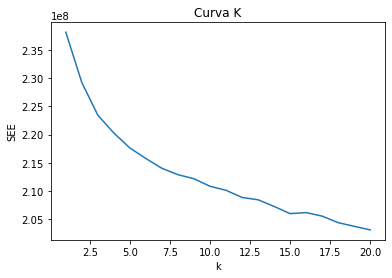

In [20]:
print_k(df[pca_columns])

Montamos el modelo de kmeans con el número de cluster igual a 5. Esto es un número mayor que las clases a diferenciar pero parece sensato intentar encontrar subgrupos dentro de las imágenes de girasoles y rosas, además de una tercera clase que sería "desconocido" (ya que hay muchas imágenes que no son ni girasoles ni rosas)

In [21]:
k =5
kmeans = KMeans(n_clusters = k)

Asignamos a cada imagen su etiqueta.

In [22]:
df['labels_kmeans'] = kmeans.fit_predict(df[pca_columns])

Text(0, 0.5, 'Count')

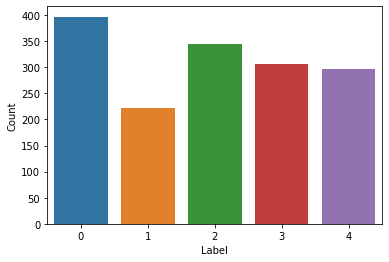

In [23]:
sns.countplot(x=df['labels_kmeans'])
plt.xlabel("Label")
plt.ylabel("Count")

In [24]:
df.labels_kmeans.value_counts()

0    397
2    345
3    307
4    296
1    222
Name: labels_kmeans, dtype: int64

# Enriquecimiento Dataset

Obtenemos los centroides:

In [25]:
centroids = kmeans.cluster_centers_

df_centroides = pd.DataFrame(centroids)
df_centroides.columns = pca_columns
df_centroides

pca_1      pca_2      pca_3      pca_4      pca_5      pca_6  \
0  -75.955201  87.238977 -14.037450  -3.577069   3.217744  -6.232102   
1  112.210377  -2.230002 -49.278129 -44.050445  15.358437   0.941350   
2   76.213651  13.012198  61.842925  -2.972101 -11.056999  13.806227   
3  -81.973264 -82.358867  18.757628  -9.151937   4.470526  20.522378   
4   13.904032 -45.080574 -35.749286  50.791604  -7.583799 -29.724168   

      pca_7      pca_8      pca_9     pca_10  ...   pca_685   pca_686  \
0 -0.405510  -0.559046  -2.396400   0.449646  ...  0.083292  0.144422   
1 -7.597255  21.352528  -1.698705  13.337104  ... -0.449371 -0.327139   
2  6.909613  -8.706883  -1.248012  -1.550143  ...  0.017623  0.315152   
3  0.983880  16.416597  11.817335   6.313781  ... -0.476631 -0.152320   
4 -2.832059 -22.143043  -6.313765 -15.347561  ...  0.699119 -0.157689   

    pca_687   pca_688   pca_689   pca_690   pca_691   pca_692   pca_693  \
0 -0.078052  0.049620  0.022132 -0.305905 -0.173583  0.046668  0.070381   
1  0.238195  0.004407  0.100567 -0.321372 -0.129669 -0.031058 -0.229890   
2 -0.225798  0.072132  0.004510  0.288938  0.069052  0.005119 -0.084111   
3  0.042748 -0.285258 -0.326136  0.186603 -0.027074 -0.050172 -0.063125   
4  0.144879  0.141931  0.227892  0.121007  0.277662  0.006772  0.241527   

    pca_694  
0  0.045421  
1 -0.020990  
2  0.065143  
3  0.169676  
4 -0.297086  

[5 rows x 694 columns]

Veamos cómo es la distribución según las etiquetas:

In [26]:
def dist_centroid(df, columns, df_cent, norm = True):
    """Función que añade al DF las distancias a cada centroide en columnas nombradas 'dis_centroid_i'

    Args:
        df (Pandas df): contiene todas las features
        pca_columns ( lista): lista que contiene todas las columnas de las features originales
        df_centroides (Pandas dF): [description]contiene las coordenadas de todos los centroides
        norm (boolean): normaliza o no la salida
    """

    columns_dist=['dist_centroid_' + str(i) for i in df_cent.index]
    for i in df_cent.index: 
        df[columns_dist[i]] = np.sqrt(((df[columns].sub(df_cent.iloc[i].tolist(), axis= 'columns'))**2).sum(axis=1))
    if norm:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(df[columns_dist])
        df[columns_dist] = data_scaled
    return df

In [27]:
def dist_centroid(df, columns, df_cent):
    """
    Función que añade al DF las distancias a cada centroide en columnas nombradas 'dis_centroid_i'

    Args:
        df (Pandas df): contiene todas las features
        pca_columns ( lista): lista que contiene todas las columnas de las features originales
        df_centroides (Pandas dF): [description]contiene las coordenadas de todos los centroides
    """

    columns_dist=['dist_centroid_' + str(i) for i in df_cent.index]
    for i in df_cent.index: 
        df[columns_dist[i]] = np.sqrt(((df[columns].sub(df_cent.iloc[i].tolist(), axis= 'columns'))**2).sum(axis=1))
    return df

Guardamos los centroides para poder enriquecer el dataset cuando tengamos imágenes sin etiquetar.

In [28]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns= pca_columns)
centroids

pca_1      pca_2      pca_3      pca_4      pca_5      pca_6  \
0  -75.955201  87.238977 -14.037450  -3.577069   3.217744  -6.232102   
1  112.210377  -2.230002 -49.278129 -44.050445  15.358437   0.941350   
2   76.213651  13.012198  61.842925  -2.972101 -11.056999  13.806227   
3  -81.973264 -82.358867  18.757628  -9.151937   4.470526  20.522378   
4   13.904032 -45.080574 -35.749286  50.791604  -7.583799 -29.724168   

      pca_7      pca_8      pca_9     pca_10  ...   pca_685   pca_686  \
0 -0.405510  -0.559046  -2.396400   0.449646  ...  0.083292  0.144422   
1 -7.597255  21.352528  -1.698705  13.337104  ... -0.449371 -0.327139   
2  6.909613  -8.706883  -1.248012  -1.550143  ...  0.017623  0.315152   
3  0.983880  16.416597  11.817335   6.313781  ... -0.476631 -0.152320   
4 -2.832059 -22.143043  -6.313765 -15.347561  ...  0.699119 -0.157689   

    pca_687   pca_688   pca_689   pca_690   pca_691   pca_692   pca_693  \
0 -0.078052  0.049620  0.022132 -0.305905 -0.173583  0.046668  0.070381   
1  0.238195  0.004407  0.100567 -0.321372 -0.129669 -0.031058 -0.229890   
2 -0.225798  0.072132  0.004510  0.288938  0.069052  0.005119 -0.084111   
3  0.042748 -0.285258 -0.326136  0.186603 -0.027074 -0.050172 -0.063125   
4  0.144879  0.141931  0.227892  0.121007  0.277662  0.006772  0.241527   

    pca_694  
0  0.045421  
1 -0.020990  
2  0.065143  
3  0.169676  
4 -0.297086  

[5 rows x 694 columns]

Calculamos la distancia al centroide

In [29]:
df = dist_centroid(df, pca_columns, df_centroides)
df.sample(3)

path            file  \
276   /Users/emilio/Trabajo/komorebi/imgs/imagen1304...  imagen1304.jpg   
1495  /Users/emilio/Trabajo/komorebi/imgs/imagen1053...  imagen1053.jpg   
725   /Users/emilio/Trabajo/komorebi/imgs/imagen1400...  imagen1400.jpg   

                                    image_original_size  \
276   <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1495  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
725   <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                                  image        size  \
276   <PIL.Image.Image image mode=RGB size=200x200 a...  (500, 281)   
1495  <PIL.Image.Image image mode=RGB size=200x200 a...  (320, 213)   
725   <PIL.Image.Image image mode=RGB size=200x200 a...  (500, 375)   

                                               features  \
276   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1495  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
725   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           features_pca       pca_1  \
276   [134.07597366023435, 44.8449544289583, 95.1514...  134.075974   
1495  [-64.95749119944703, 17.96523911437919, 8.9989...  -64.957491   
725   [93.61141798972204, -28.73221617296931, -67.93...   93.611418   

          pca_2      pca_3  ...   pca_691    pca_692    pca_693    pca_694  \
276   44.844954  95.151438  ... -5.021647 -13.456112 -16.909433 -15.478540   
1495  17.965239   8.998919  ... -4.461764   6.881694  -1.124811   3.039772   
725  -28.732216 -67.939325  ... -0.135108   4.507267   1.221323 -21.991757   

      labels_kmeans  dist_centroid_0  dist_centroid_1  dist_centroid_2  \
276               2       451.065226       417.346746       389.465255   
1495              0       290.347875       339.306455       324.262880   
725               1       427.916023       375.711556       396.583326   

      dist_centroid_3  dist_centroid_4  
276        465.416979       436.116948  
1495       306.994088       318.131202  
725        424.953361       394.107442  

[3 rows x 707 columns]

# Nombramiento de etiquetas

Podemos ver cómo ha etiquetado cada imagen el k menas

In [30]:
def print_flowers_cat(df, labels = 'labels_kmeans', num = 16, label_text=None):
    """Imprime por pantalla imágenes aleatorias contenidas ean un dataset agrupadas por etiquetas. Si label_text no está vacía pregunta por las etiquetas de cada una de las categorías.

    Args:
        df (Pandas DF): Pandas dataframe conteniendo imágenes
        labels (str, optional): Columna que contiene la etiqueta d ecada imagen. Defaults to 'labels_kmeans'.
        num (int, optional): Número de imágenes a mostrar. Defaults to 16.
        label_text (list of strings, optional): lista con etiquetas. Defauls to 'None'. Si None no se pregunta por el nombre de las categorias.

    Returns:
        Diccionario con el texto asociado a cada una de las etiquetas. Si no se ha preguntado devuelve None
    """
    dict_ = dict()
    for i in df[labels].unique():
        print("===============================")
        print("Etiqueta: ", i)
        print_flowers(df[df[labels] == i],num)
        plt.show()
        if label_text:
            question = [str(i) + '-' + s  for i,s in enumerate(label_text)]
            dict_[i] = label_text[int(input(question))]

    return dict_

Etiqueta:  2
Número de imágenes:  345


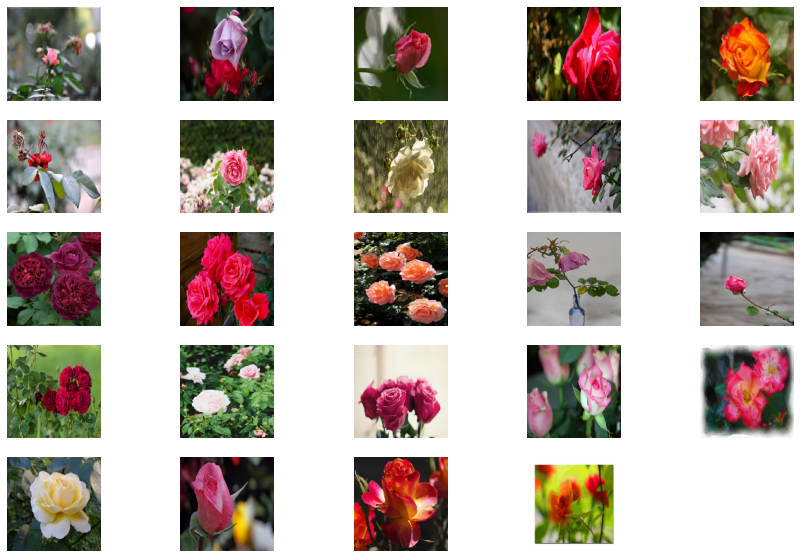

Etiqueta:  0
Número de imágenes:  397


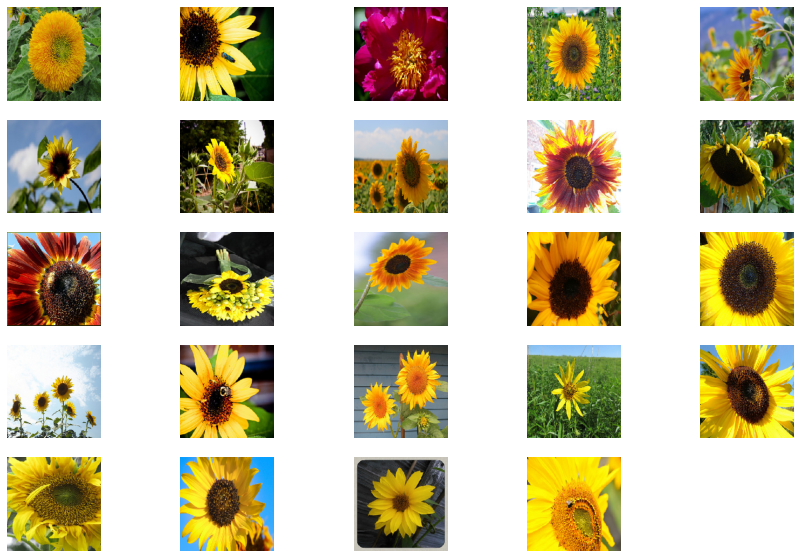

Etiqueta:  3
Número de imágenes:  307


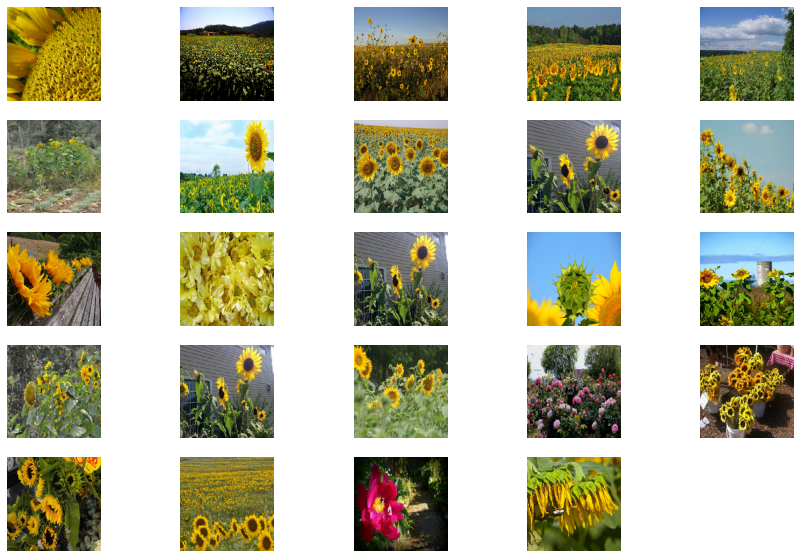

Etiqueta:  1
Número de imágenes:  222


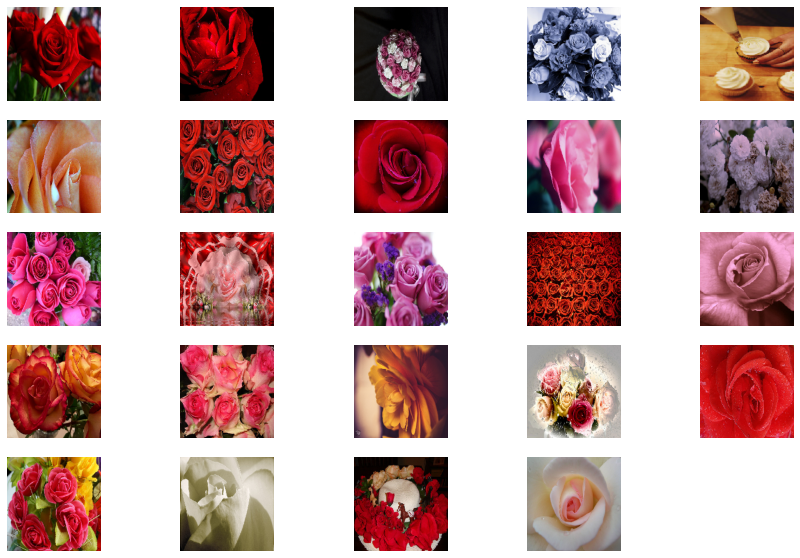

Etiqueta:  4
Número de imágenes:  296


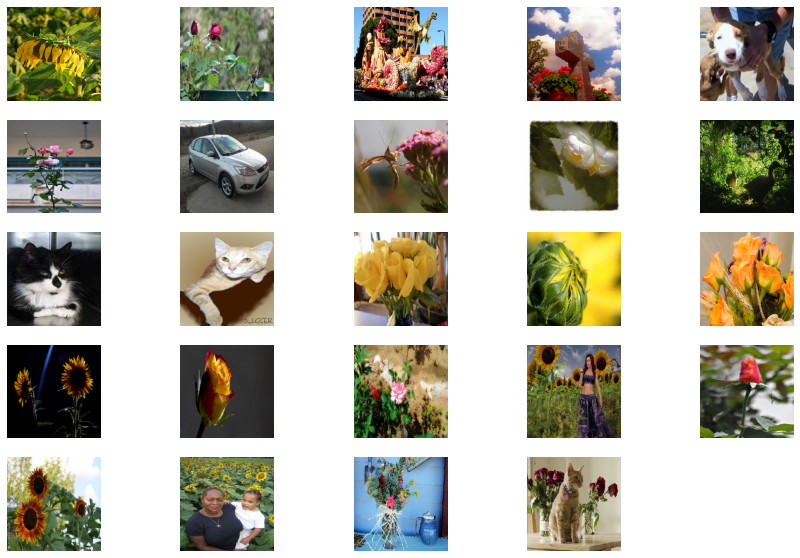

In [31]:
dict_ = print_flowers_cat(df, num= 24, label_text = ['Others', 'Roses', 'Sunflowers'])

Vemos cómo las flores se agrupan en 2 grupos de girasoles, otros 2 de rosas y uno compuesto mayoritariamente por otro tipo de imágenes.

Agrupamos las etiquetas y ponemos nombre a cada una:

In [32]:

df["kmeans_label_name"] = df.labels_kmeans.map(dict_)

Etiqueta:  Roses
Número de imágenes:  567


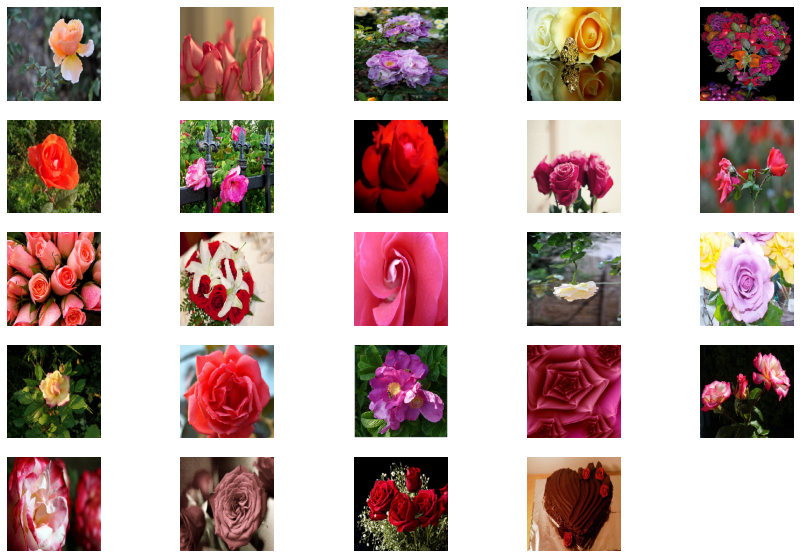

Etiqueta:  Sunflowers
Número de imágenes:  704


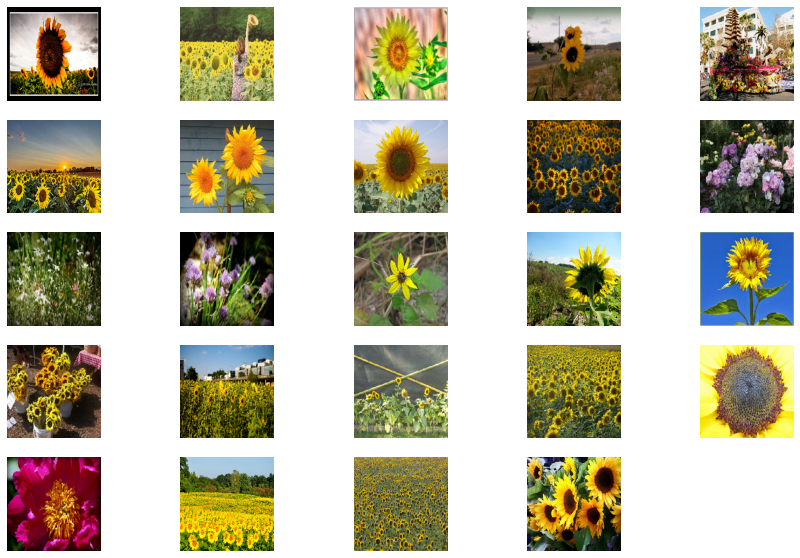

Etiqueta:  Others
Número de imágenes:  296


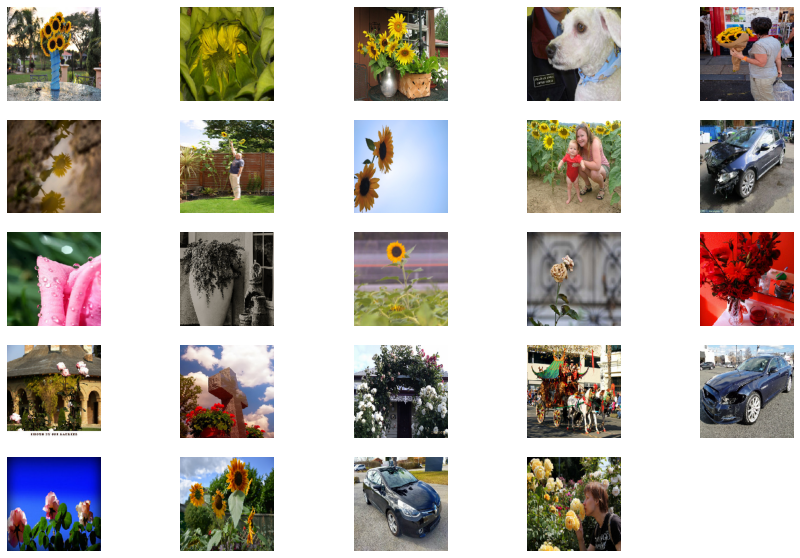

{}

In [33]:
print_flowers_cat(df, labels='kmeans_label_name', num= 24)

# MLP
Utilizamos un Multi-layer Perceptron classifier. En este caso, como buscamos huir del overfitting montamos un clasificador con muy pocas capas.

In [34]:
columns_dist=['dist_centroid_' + str(i) for i in range(k)]

scaler = StandardScaler()
df[pca_columns + columns_dist] = pd.DataFrame(scaler.fit_transform(df[pca_columns + columns_dist]))

In [35]:
clf = MLPClassifier(hidden_layer_sizes=(3,))

columns_dist=['dist_centroid_' + str(i) for i in range(k)]
clf.fit(df[columns_dist + pca_columns],df['labels_kmeans'])

/opt/homebrew/Caskroom/miniconda/base/envs/test/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(3,))

Computamos la clasificación que nos haría

In [36]:
df['labels_mplp'] = clf.predict(df[columns_dist + pca_columns])

Y la probabilidad.

In [37]:
df['mplp_predict_proba'] = clf.predict_proba(df[columns_dist + pca_columns]).tolist()

In [38]:

df["mlpc_label_name"] = df.labels_mplp.map(dict_)

In [39]:
df = df.assign(mlp_predict_proba_single = df[['mplp_predict_proba', 'labels_mplp']].apply(lambda rows: rows[0][rows[1]], axis =1))

Algunas etiquetas coinciden con las del proceso de clustering pero otras no:

In [40]:
df_diff = df[df.labels_kmeans != df.labels_mplp]

Veamos los valores superiores de la red MLPC:

In [41]:
df_diff[['file', 'mlp_predict_proba_single']].sort_values('mlp_predict_proba_single', ascending = False).head(5)

file  mlp_predict_proba_single
1521     imagen2.jpg                  0.661567
687   imagen1560.jpg                  0.649996
444   imagen1405.jpg                  0.641371
1331    imagen17.jpg                  0.635801
1393   imagen243.jpg                  0.628552

Y los valores inferiores

In [42]:
df_diff[['file', 'mlp_predict_proba_single'] ].sort_values('mlp_predict_proba_single', ascending = False).tail(5)

file  mlp_predict_proba_single
721   imagen175.jpg                  0.408851
351   imagen670.jpg                  0.407955
546   imagen836.jpg                  0.406270
1457  imagen861.jpg                  0.402849
198   imagen302.jpg                  0.395742

In [43]:
df_diff = df[df.kmeans_label_name != df.mlpc_label_name]
print("No coinciden ", df_diff.shape[0], " imágenes")


No coinciden  158  imágenes


In [44]:
df_diff[['kmeans_label_name', 'mlpc_label_name', 'mlp_predict_proba_single']].sort_values(by=['mlp_predict_proba_single'])

kmeans_label_name mlpc_label_name  mlp_predict_proba_single
198              Roses      Sunflowers                  0.395742
1457             Roses      Sunflowers                  0.402849
546              Roses      Sunflowers                  0.406270
351              Roses      Sunflowers                  0.407955
721              Roses      Sunflowers                  0.408851
...                ...             ...                       ...
1162            Others      Sunflowers                  0.602587
1393            Others      Sunflowers                  0.628552
1331            Others      Sunflowers                  0.635801
444             Others      Sunflowers                  0.641371
1521            Others      Sunflowers                  0.661567

[158 rows x 3 columns]

Y su distribución

Text(0, 0.5, 'Count')

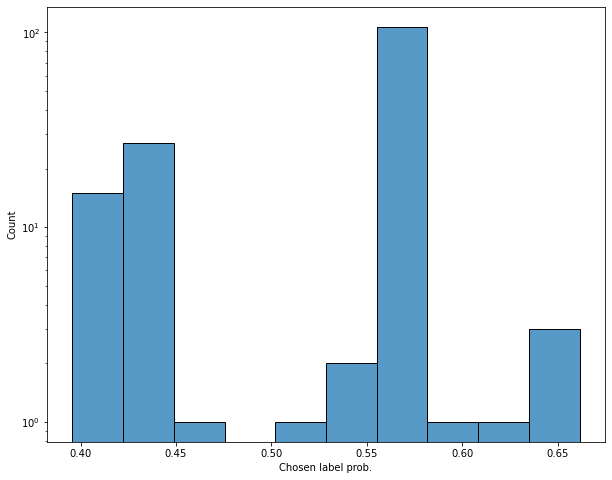

In [45]:

plt.figure(figsize=(10,8))
plt.yscale('log')
sns.histplot(df_diff['mlp_predict_proba_single'], bins=10)
plt.xlabel("Chosen label prob.")
plt.ylabel("Count")

Veamos algunas de ellas:

In [46]:
def print_flowers_diff(df, *args, num_examples = 9, col='image', size = (15,10)):
    """Función que imprime por consola un número imágenes aleatoriamente escogidas de un Pandas dataframe.

    Args:
        df (Pandas dataframe): Dataframe contenedor de imágenes
        num_examples (int, optional): Número de imágenes a mostrar. Defaults to 9.
        col (str, optional): Nombre de la columna que contiene las imágenes. Defaults to 'image'.
        size (tuple, optional): Tamaño de la figura que contiene las imágenes. Defaults to (15,10).
    """
    
    try:
        num_imgs_df = df.shape[0]
        num_imgs_show = min(num_examples, num_imgs_df)

        print("Número de imágenes: ", num_imgs_df)

        df_examples = df.sample(num_imgs_show).reset_index()
        gs = gridspec.GridSpec( int(np.ceil(np.sqrt(num_imgs_show))), int(np.ceil(np.sqrt(num_imgs_show))))
        gs.update(hspace = 0.75)
        plt.figure(figsize = size)

        for i in range(0, num_imgs_show):
            plt.subplot(gs[i])
            plt.imshow(df_examples.reset_index()[col][i])    
            tit = ["{}: {}".format(k,df_examples.loc[i,k]) for k in list(args)]
            plt.title('\n'.join(tit) + '\n' + str(round(df_examples.mlp_predict_proba_single[i],2)))
            plt.axis('off')
    except Exception as e:
        print("Ha surgido un problemaal imprimir")
        print(e)


Veamos las imágenes que diferencian entre uno y otro.

Número de imágenes:  158


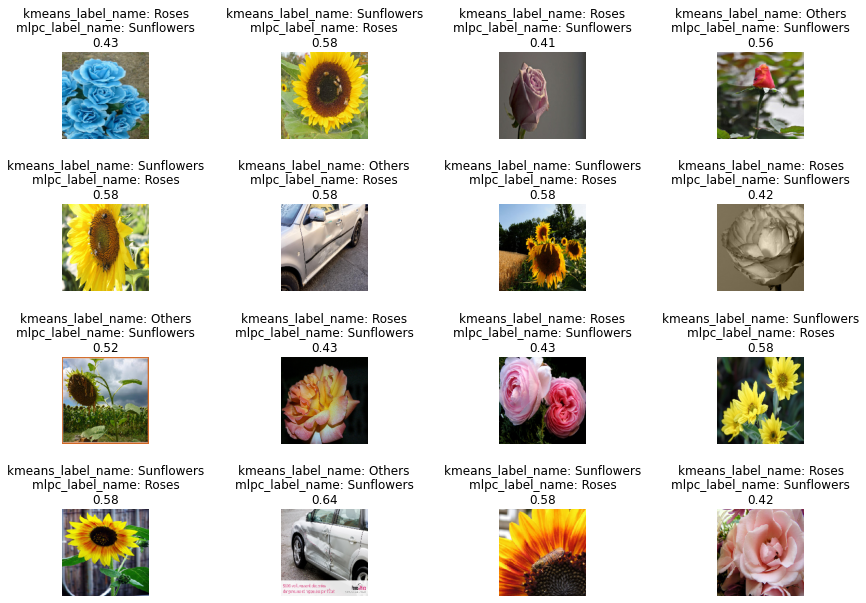

In [47]:
df_diff_print = df_diff[['image','kmeans_label_name', 'mlpc_label_name', 'mlp_predict_proba_single']]
print_flowers_diff(df_diff_print,'kmeans_label_name', 'mlpc_label_name', num_examples = 16)

Almacenamos la probabilidad con la que el Clsificador a elegido cada imagen

In [48]:
df = df.assign(mlp_predict_proba_single = df[['mplp_predict_proba', 'labels_mplp']].apply(lambda rows: rows[0][rows[1]], axis =1))

In [55]:
def decide_label(row, th=0.5):
    """Función que utilizaremos para determinar la etiqueta final. 

    Args:
        row (PD Serie: Fila compuesta por ['labels_kmeans', 'labels_mplp', 'mlp_predict_proba_single']
        th (float, optional): Umbral para considerar si mantener la etiqueta del K means o el Clasificador. Defaults to 0.3.

    Returns:
        int : Etiqueta decidida.
    """
    if row[0] == row[1] or row[2] > th:
        return row[1]
    else:
        return row[0]
    

df = df.assign(label= df[['kmeans_label_name', 'mlpc_label_name', 'mlp_predict_proba_single']].apply(lambda rows: decide_label(rows, th=0.7), axis = 1 ))

Número de imágenes:  158


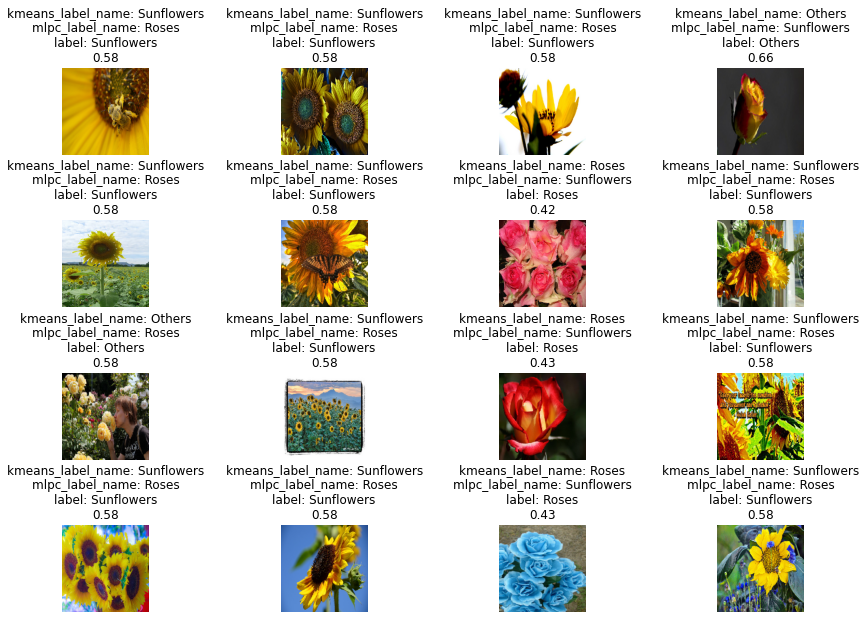

In [56]:
df_diff = df[df.kmeans_label_name != df.mlpc_label_name]
df_diff_print = df_diff[['image','kmeans_label_name', 'mlpc_label_name', 'mlp_predict_proba_single','label']]
print_flowers_diff(df_diff_print,'kmeans_label_name', 'mlpc_label_name','label', num_examples = 16)

En esta imagen podemos ver algunos ejemplos del refinamiento. Las imagenes con etiquetas diferentes en las que la probaibilidad del mlpc es mayor que el umbral se corrigen.

En la siguiente gráfica podemos ver cómo se han distribuido las etiquetas

/opt/homebrew/Caskroom/miniconda/base/envs/test/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'count')

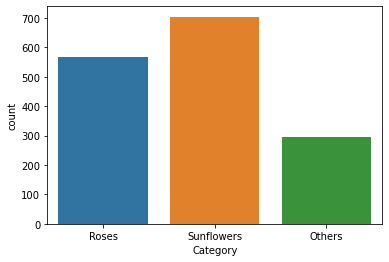

In [57]:
sns.countplot(df.label)
plt.xlabel("Category")
plt.ylabel("count")

En la siguiente gráfica podemos ver cuál ha sido la probabilidad que se ha dado para la etiqueta elegida

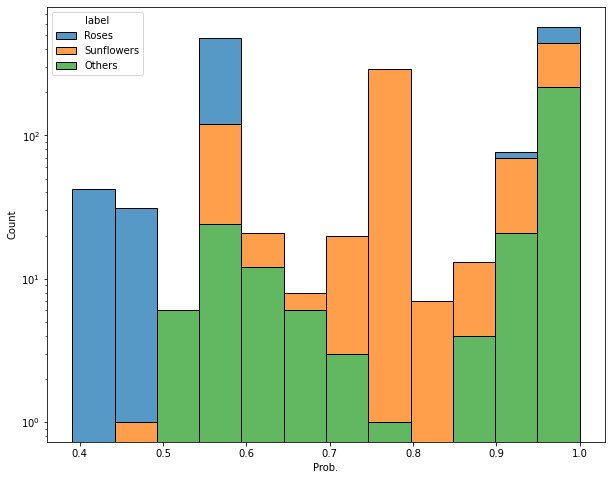

In [58]:
plt.figure(figsize=(10,8))
sns.histplot(df,x='mlp_predict_proba_single',hue='label', multiple='stack')
plt.ylabel("Count")
plt.xlabel("Prob.")
plt.yscale('log')

En esta gráfica vemos como se distribuye las imágenes en función de la probabilidad resultante de MLPC. Las agrupamos por etiquetas. 

Por último guardamos las imágenes por carpetas con la fecha y hora del momento en que se ejecutó:



In [59]:
def save_img_cat_folder(df, folder,  labels= 'label'):
    date_time = datetime.now().strftime("%d%m%Y%H%M%S")
    dir_= os.path.join('./',folder + date_time)
    
    os.mkdir(dir_)
    
    for l in df[labels].unique():
        dir_cat= os.path.join(dir_,str(l))
        os.mkdir(dir_cat)

        files_paths = df[df[labels] == l ].path.tolist()
        files_names = df[df[labels] == l ].file.tolist()

        for origin_path, f_name in zip(files_paths, files_names):
            dir_dest = os.path.join(dir_cat, f_name)
            shutil.copy(origin_path, dir_dest)

In [60]:
save_img_cat_folder(df, 'Label Sunflower vs Roses',  labels= 'label')


---------------------
Emilio Carrasco Moreno

emilioemail@gmail.com

+34 654642257